In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.models import model_from_json

In [3]:
import plotting
from sklearn.metrics import accuracy_score

In [4]:
data_loc = '/gpfs/slac/atlas/fs1/d/rafaeltl/public/ML/L1RNN/datasets_2020_ff/'
file_str = 'Jan06_FlavFix_smear_1_std_xtd_zst.h5'

In [5]:
f5 = h5py.File(data_loc+file_str, 'r')

In [6]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

In [7]:
nLSTM = [2, 10, 20, 50, 100]

nDense = ["", 10, 50]

nL = [0, 0.001]

nlstm = "100"
ndense = "10"
nl1 = "0"
nl2 = "0"

model_name = f"rnn_LSTM.{nlstm}_Dense.{ndense}_LSTMKernelInit.VarianceScaling_DenseKernelInit.lecun_uniformKRl1.{nl1}_KRl2.{nl2}_recAct.sigmoid"

In [8]:
arch_json = open('/gpfs/slac/atlas/fs1/u/rafaeltl/ML/L1BTag/Mar28/hls-rnn-btag/notebooks/keras/model_'+model_name+'_arch.json', 'r').read()
model = model_from_json(arch_json)
model.load_weights(f'/gpfs/slac/atlas/fs1/u/rafaeltl/ML/L1BTag/Mar28/hls-rnn-btag/notebooks/keras/model_{model_name}_weights.h5')

In [9]:
y_keras = model.predict(x_test, batch_size=2**10)

In [10]:
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))

Accuracy: 0.7245135539664062


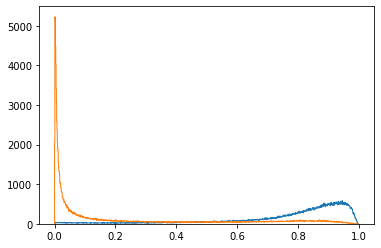

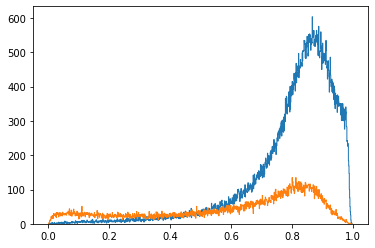

In [11]:
pb_b = y_keras[:,0] [y_test[:,0] == 1]
pc_b = y_keras[:,1] [y_test[:,0] == 1]
pl_b = y_keras[:,2] [y_test[:,0] == 1]
    
pc_c = y_keras[:,1] [y_test[:,1] == 1]
pb_c = y_keras[:,0] [y_test[:,1] == 1]
    
pl_l = y_keras[:,2] [y_test[:,2] == 1]
pb_l = y_keras[:,0] [y_test[:,2] == 1]

plt.Figure()

plt.hist( pb_b/(pb_b+pl_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_l/(pb_l+pl_l), range=(0,1), bins=1000, histtype='step' )

plt.show()


plt.Figure()

plt.hist( pb_b/(pb_b+pc_b), range=(0,1), bins=1000, histtype='step' )
plt.hist( pb_c/(pb_c+pc_c), range=(0,1), bins=1000, histtype='step' )

plt.show()

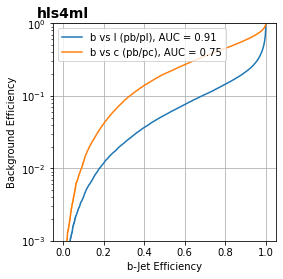

In [12]:
plt.figure(figsize=(4,4))
_ = plotting.makeRoc(y_test, y_keras)

In [13]:
import hls4ml

/src/hls4ml/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [14]:
config = hls4ml.utils.config_from_keras_model(model, granularity='model')

Interpreting Model
Topology:
Layer name: input_2, layer type: Input
Layer name: lstm1, layer type: LSTM
  -> Activation (tanh), layer name: lstm1
Layer name: dense_0, layer type: Dense
  -> Activation (relu), layer name: dense_0
Layer name: output_softmax, layer type: Dense
  -> Activation (softmax), layer name: output_softmax


In [15]:
model_suffix = '_modPrec16.6'

In [16]:
project_name = f'model_{model_name}{model_suffix}'

In [17]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir=f'{project_name}/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 15, 6]], output shape: [None, 15, 6]
Layer name: lstm1, layer type: LSTM, input shapes: [[None, 15, 6]], output shape: [None, 100]
Layer name: dense_0, layer type: Dense, input shapes: [[None, 100]], output shape: [None, 10]
Layer name: output_softmax, layer type: Dense, input shapes: [[None, 10]], output shape: [None, 3]
Creating HLS model


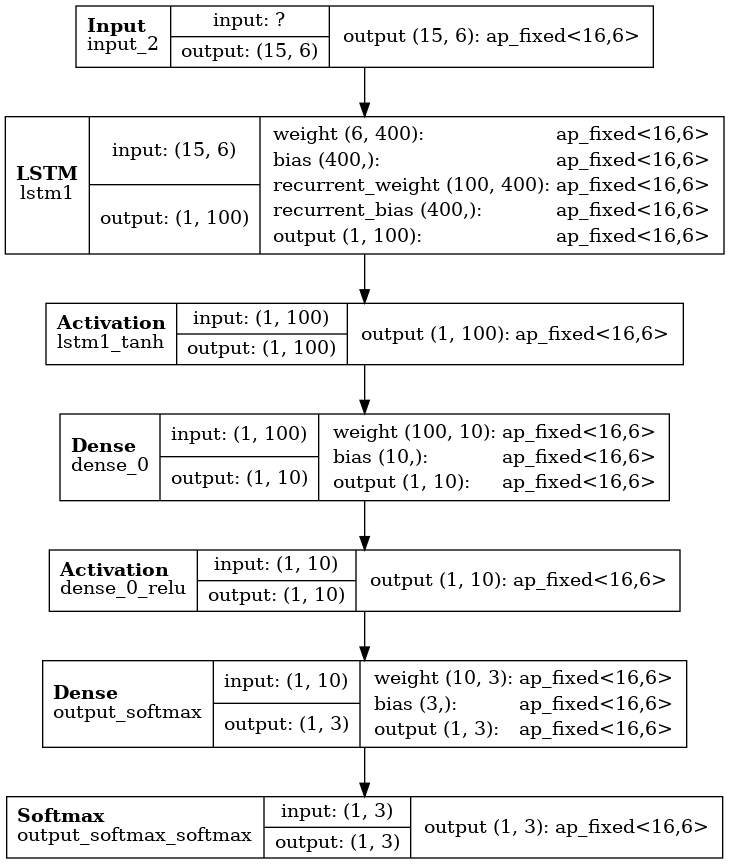

In [18]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

In [19]:
hls_model.compile()

Writing HLS project
Done


In [20]:
x_test_cont = np.ascontiguousarray(x_test[:50000,:,:])

In [21]:
y_hls = hls_model.predict(x_test_cont)

In [22]:
y_hls, y_keras

(array([[0.51660156, 0.11523438, 0.37792969],
        [0.60253906, 0.26757812, 0.13378906],
        [0.00488281, 0.00488281, 0.96386719],
        ...,
        [0.01855469, 0.01171875, 0.97753906],
        [0.74316406, 0.11328125, 0.17578125],
        [0.00878906, 0.00976562, 0.95214844]]),
 array([[0.54776144, 0.11115208, 0.34108654],
        [0.62105674, 0.26184744, 0.11709582],
        [0.00120046, 0.00248433, 0.9963152 ],
        ...,
        [0.9495357 , 0.02030302, 0.03016123],
        [0.72595996, 0.1724658 , 0.1015742 ],
        [0.5881564 , 0.17464378, 0.23719981]], dtype=float32))

Keras  Accuracy: 0.7245135539664062
hls4ml Accuracy: 0.71902


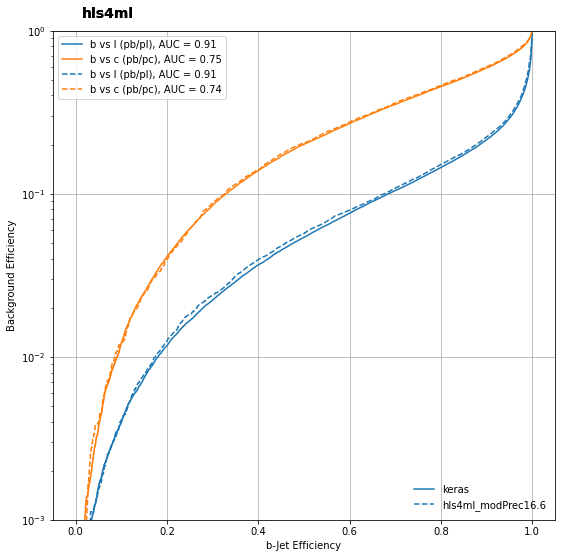

In [23]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test[:50000], axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras)

plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test[:50000], y_hls, linestyle='--')


from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', f'hls4ml{model_suffix}'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

# ax.set_title(model_name, loc='right')